In [20]:
import SIMSIToolBox
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error
import random as rd
import seaborn as sb
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import spatial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.svm import SVR
cosineSim = lambda x1,x2: 1 - spatial.distance.cosine(x1, x2)
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
import statsmodels.api as sm
import sympy as sym
import pickle as pkl

In [9]:
#goal simulate labeling patterns

n=100
c13ab = 0.0 #natural abundance
numCarbons = 16
N = np.array([(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2]) #get expected labeling of precursor from natural abundance
exprList = SIMSIToolBox.generateISAExpressions(SIMSIToolBox.getISAEq(numCarbons),numCarbons)
isa_func = sym.lambdify(*exprList)

gs = np.random.random(n)
ds = np.random.random(n)
ts = np.random.random((n,3))
ts = np.array([x/np.sum(x) for x in ts])

In [10]:
labeling_theo = []
for g,t,d in zip(gs,ts,ds):
    x = d * t + (1-d) * N
    labeling_theo.append(isa_func(x[0],x[1],x[2],N[0],N[1],N[2],g,(1-g),0))
labeling_theo = np.array(labeling_theo)

In [24]:
plt_dict = {}

for noiseFrac in np.linspace(0,.5,15):
    for g,d,t,l_true in zip(gs,ds,ts,labeling_theo):
        x_true = d * np.array(t) + (1-d) * np.array(N)
        noise = np.random.random(l_true.shape)
        noise = noiseFrac * noise / np.sum(noise)
        l_obs = (1-noiseFrac) * l_true / np.sum(l_true)
        l_obs = [l+ns for l,ns in zip(l_obs,noise)]
        l_obs = np.array(l_obs)/np.sum(l_obs)
                
        err_measure = np.mean([np.abs(x-y) for x,y in zip(l_obs,l_true)])
        
        g_pred, _,_, x_pred, err, l_pred = SIMSIToolBox.ISAFit([0,0,1],N,l_obs,exprList,list(range(len(l_obs))),np.array([0.5]))
        g_class,_, d_pred, _, err, l_pred = SIMSIToolBox.ISAFit_classical(t,N,l_obs,exprList,list(range(len(l_obs))),np.array([.5,.5]))
        x_pred_classical = d_pred * np.array(t) + (1-d_pred) * np.array(N)
        
        err_x = np.sum(np.abs(x_true-x_pred))
        err_x_classical = np.abs(sum(x_true-x_pred_classical))
        
        if g_pred > -.0001 and g_pred < 1.1 and all(xx > -0.01 and xx < 1.1 for xx in x_pred) and g_class > -.0001 and g_class < 1.1:
            plt_dict[len(plt_dict)] = {"method":"SISA","error in g(t)":np.abs(g-g_pred),"measurement error":err_measure,"error in acetyl-CoA":err_x}
            plt_dict[len(plt_dict)] = {"method":"Classical ISA","error in g(t)":np.abs(g-g_class),"measurement error":err_measure,"error in acetyl-CoA":err_x_classical}
plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
plt_dict

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\SIMSIToolBox\__init__.py:783: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: objectiveFunc(P, func(x[1]/np.sum(x[1:4]),x[2]/np.sum(x[1:4]),x[3]/np.sum(x[1:4]),N[0],N[1],N[2],x[0],1-x[0],0), goodInd),


,method,error in g(t),measurement error,error in acetyl-CoA
0,SISA,0.000003,1.839417e-17,8.425129e-05
1,Classical ISA,0.023092,1.839417e-17,4.163336e-17
2,SISA,0.000048,0.000000e+00,1.905755e-04
3,Classical ISA,0.088432,0.000000e+00,6.245005e-17
4,SISA,0.000101,0.000000e+00,1.025117e-03
...,...,...,...,...
2995,Classical ISA,0.363554,4.918416e-02,2.775558e-17
2996,SISA,0.035020,3.020591e-02,1.350535e-01
2997,Classical ISA,0.007597,3.020591e-02,5.551115e-17
2998,SISA,0.025370,3.398468e-02,7.687992e-01


error in g(t) 0.43862445074747325


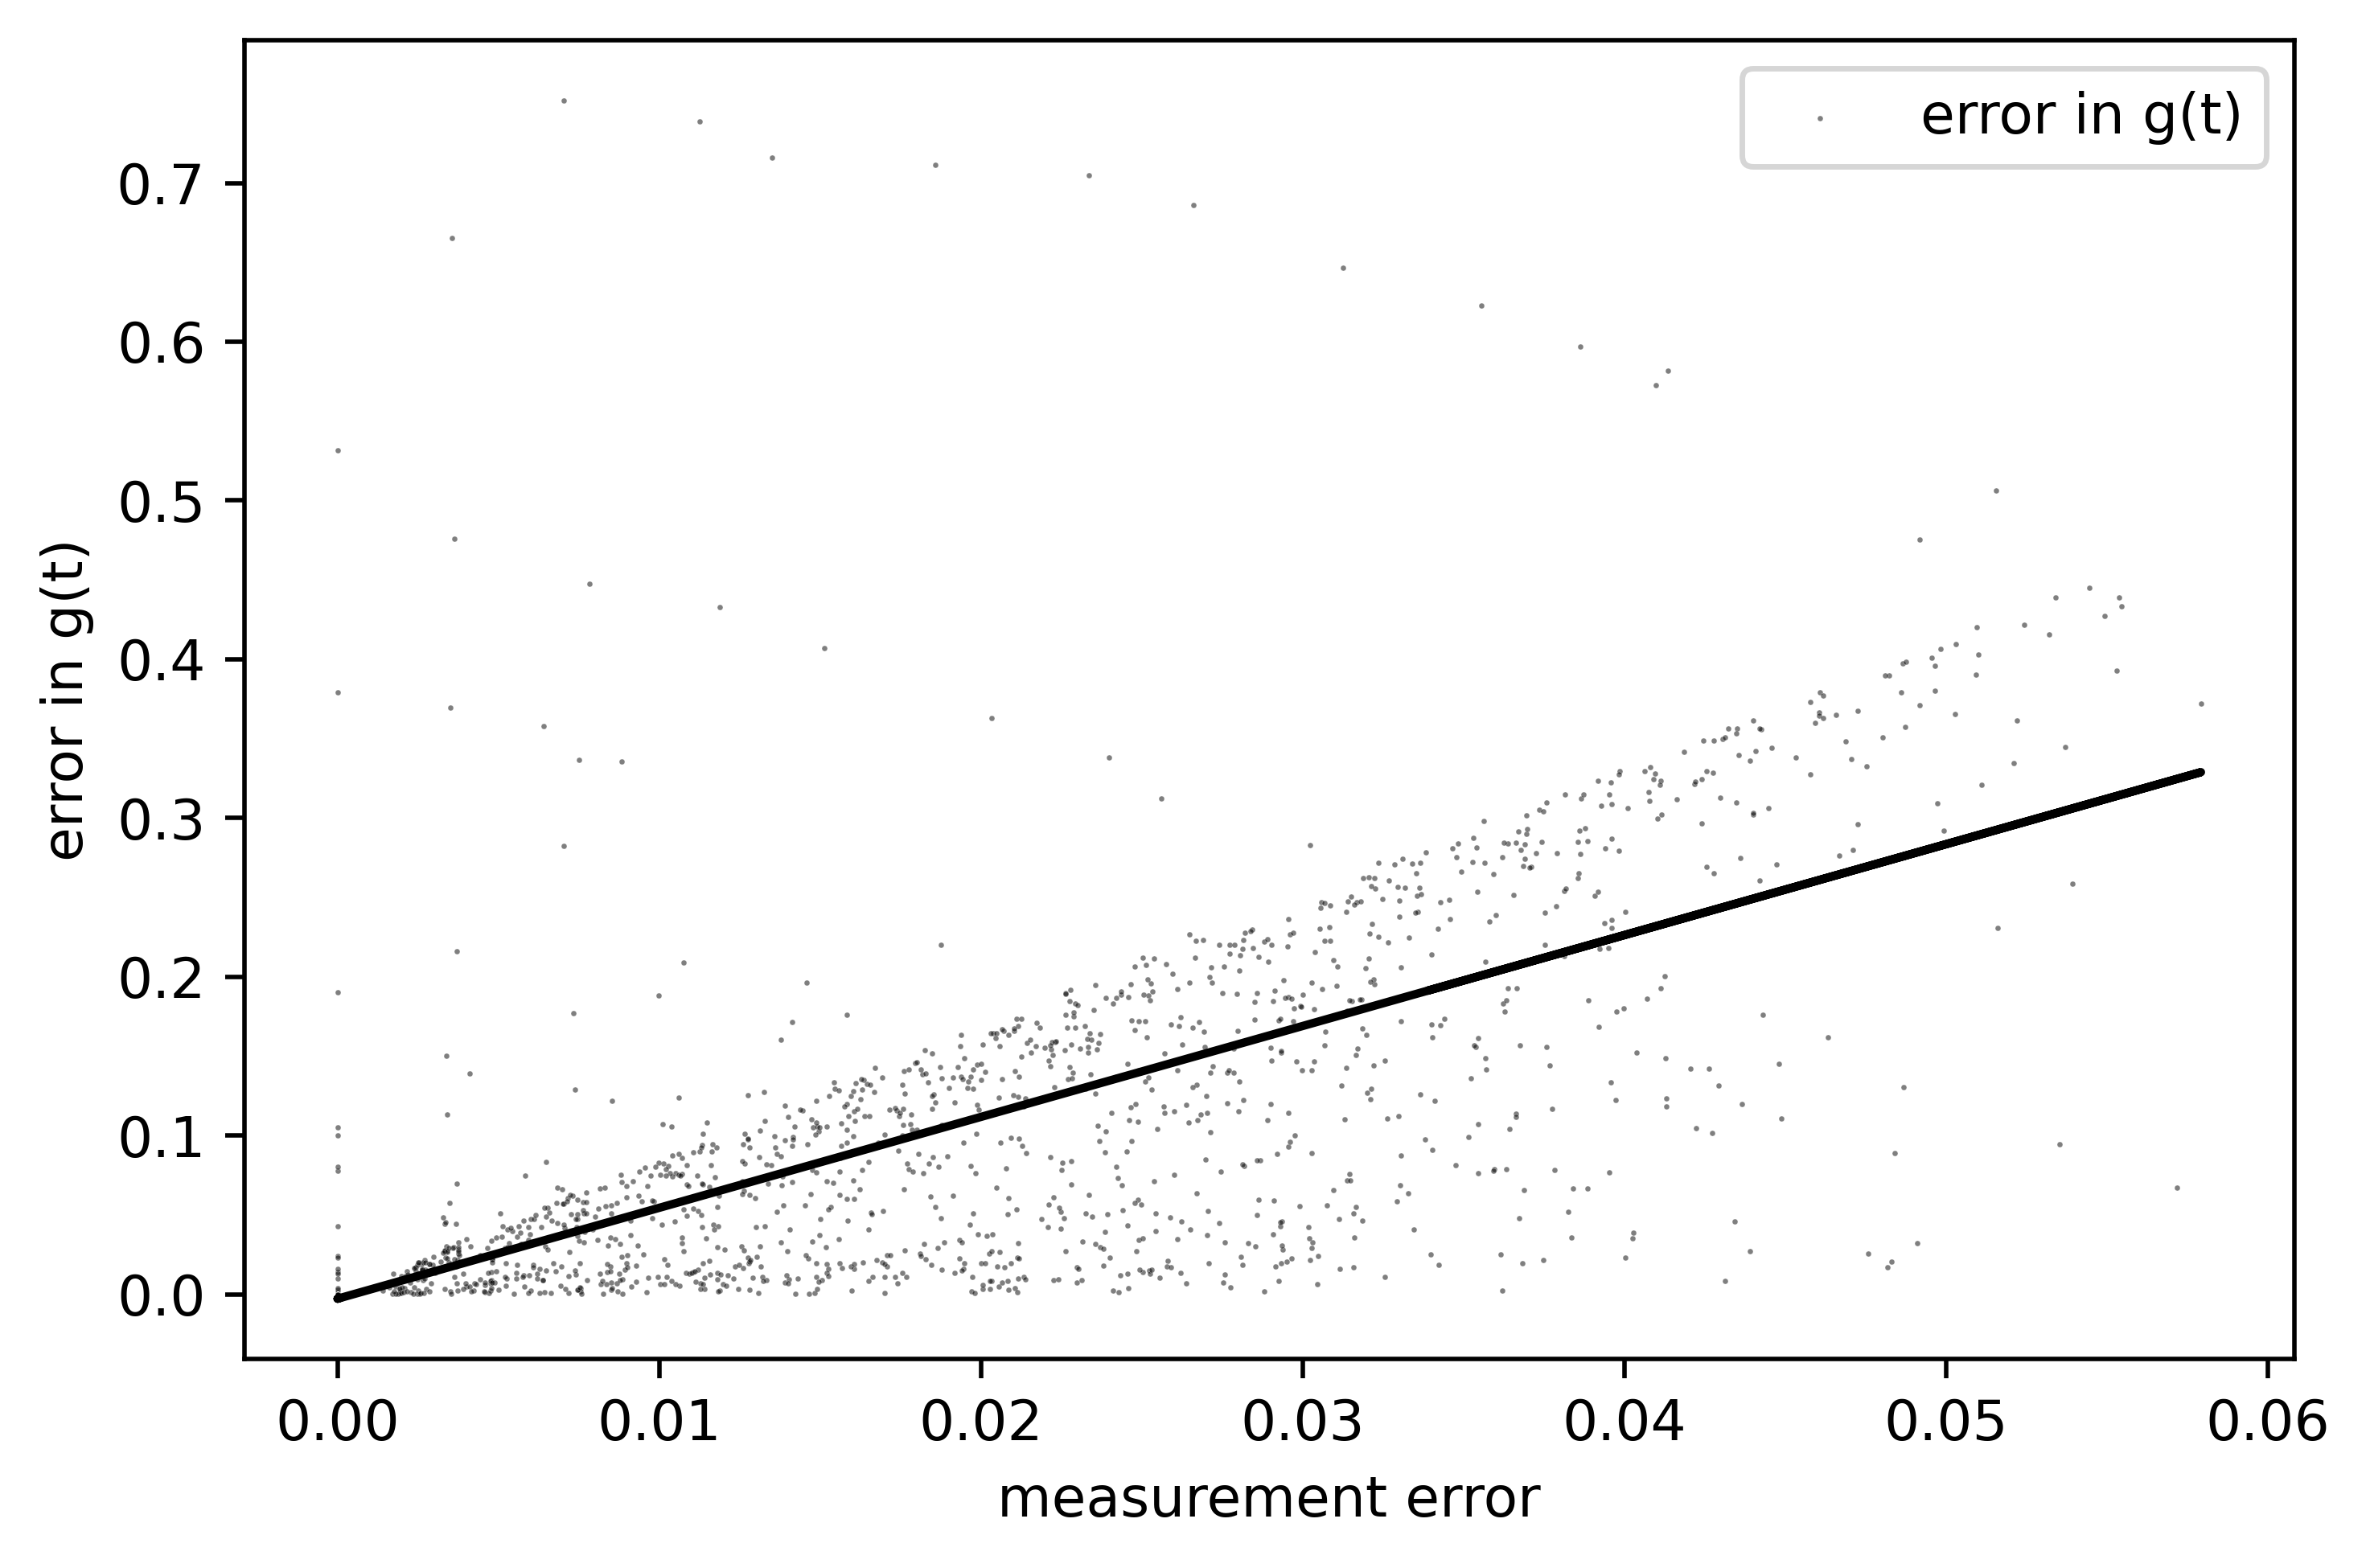

In [50]:
palette = {"error in g(t)":"black"}#,"error in acetyl-CoA":"green"}
models = {}
#sb.lineplot(data=plt_dict,x="measurement error",y="error in g(t)",hue="method",palette=palette)
for error,color in palette.items():
    filt = plt_dict[plt_dict["method"] == "SISA"]
    #sb.regplot(data=filt,x="measurement error",y=error, ci=0,scatter_kws={"s": .1,"alpha":1.0},color=color,label=error)
    sb.scatterplot(data=filt,x="measurement error",y=error, s = 1,alpha=0.5,color=color,label=error)
    linReg = LinearRegression()
    linReg.fit(filt["measurement error"].values.reshape(-1,1),filt[error].values)
    #z = lowess(filt[error].values, filt["measurement error"].values,is_sorted=False)
    #pred = interp1d(z[:,0],z[:,1])(filt["measurement error"].values)
    pred = linReg.predict(filt["measurement error"].values.reshape(-1,1))
    r2 = r2_score(filt[error].values,pred)
    plt.plot(filt["measurement error"].values,pred,color=color)
    models[error] = interp1d(filt["measurement error"].values,pred,fill_value="extrapolate")
    print(error,r2)
    
plt.ylabel("error in g(t)")
plt.tight_layout()
plt.savefig("../figures_presentations/noise_g_t_scatter.png")
#plt.legend()


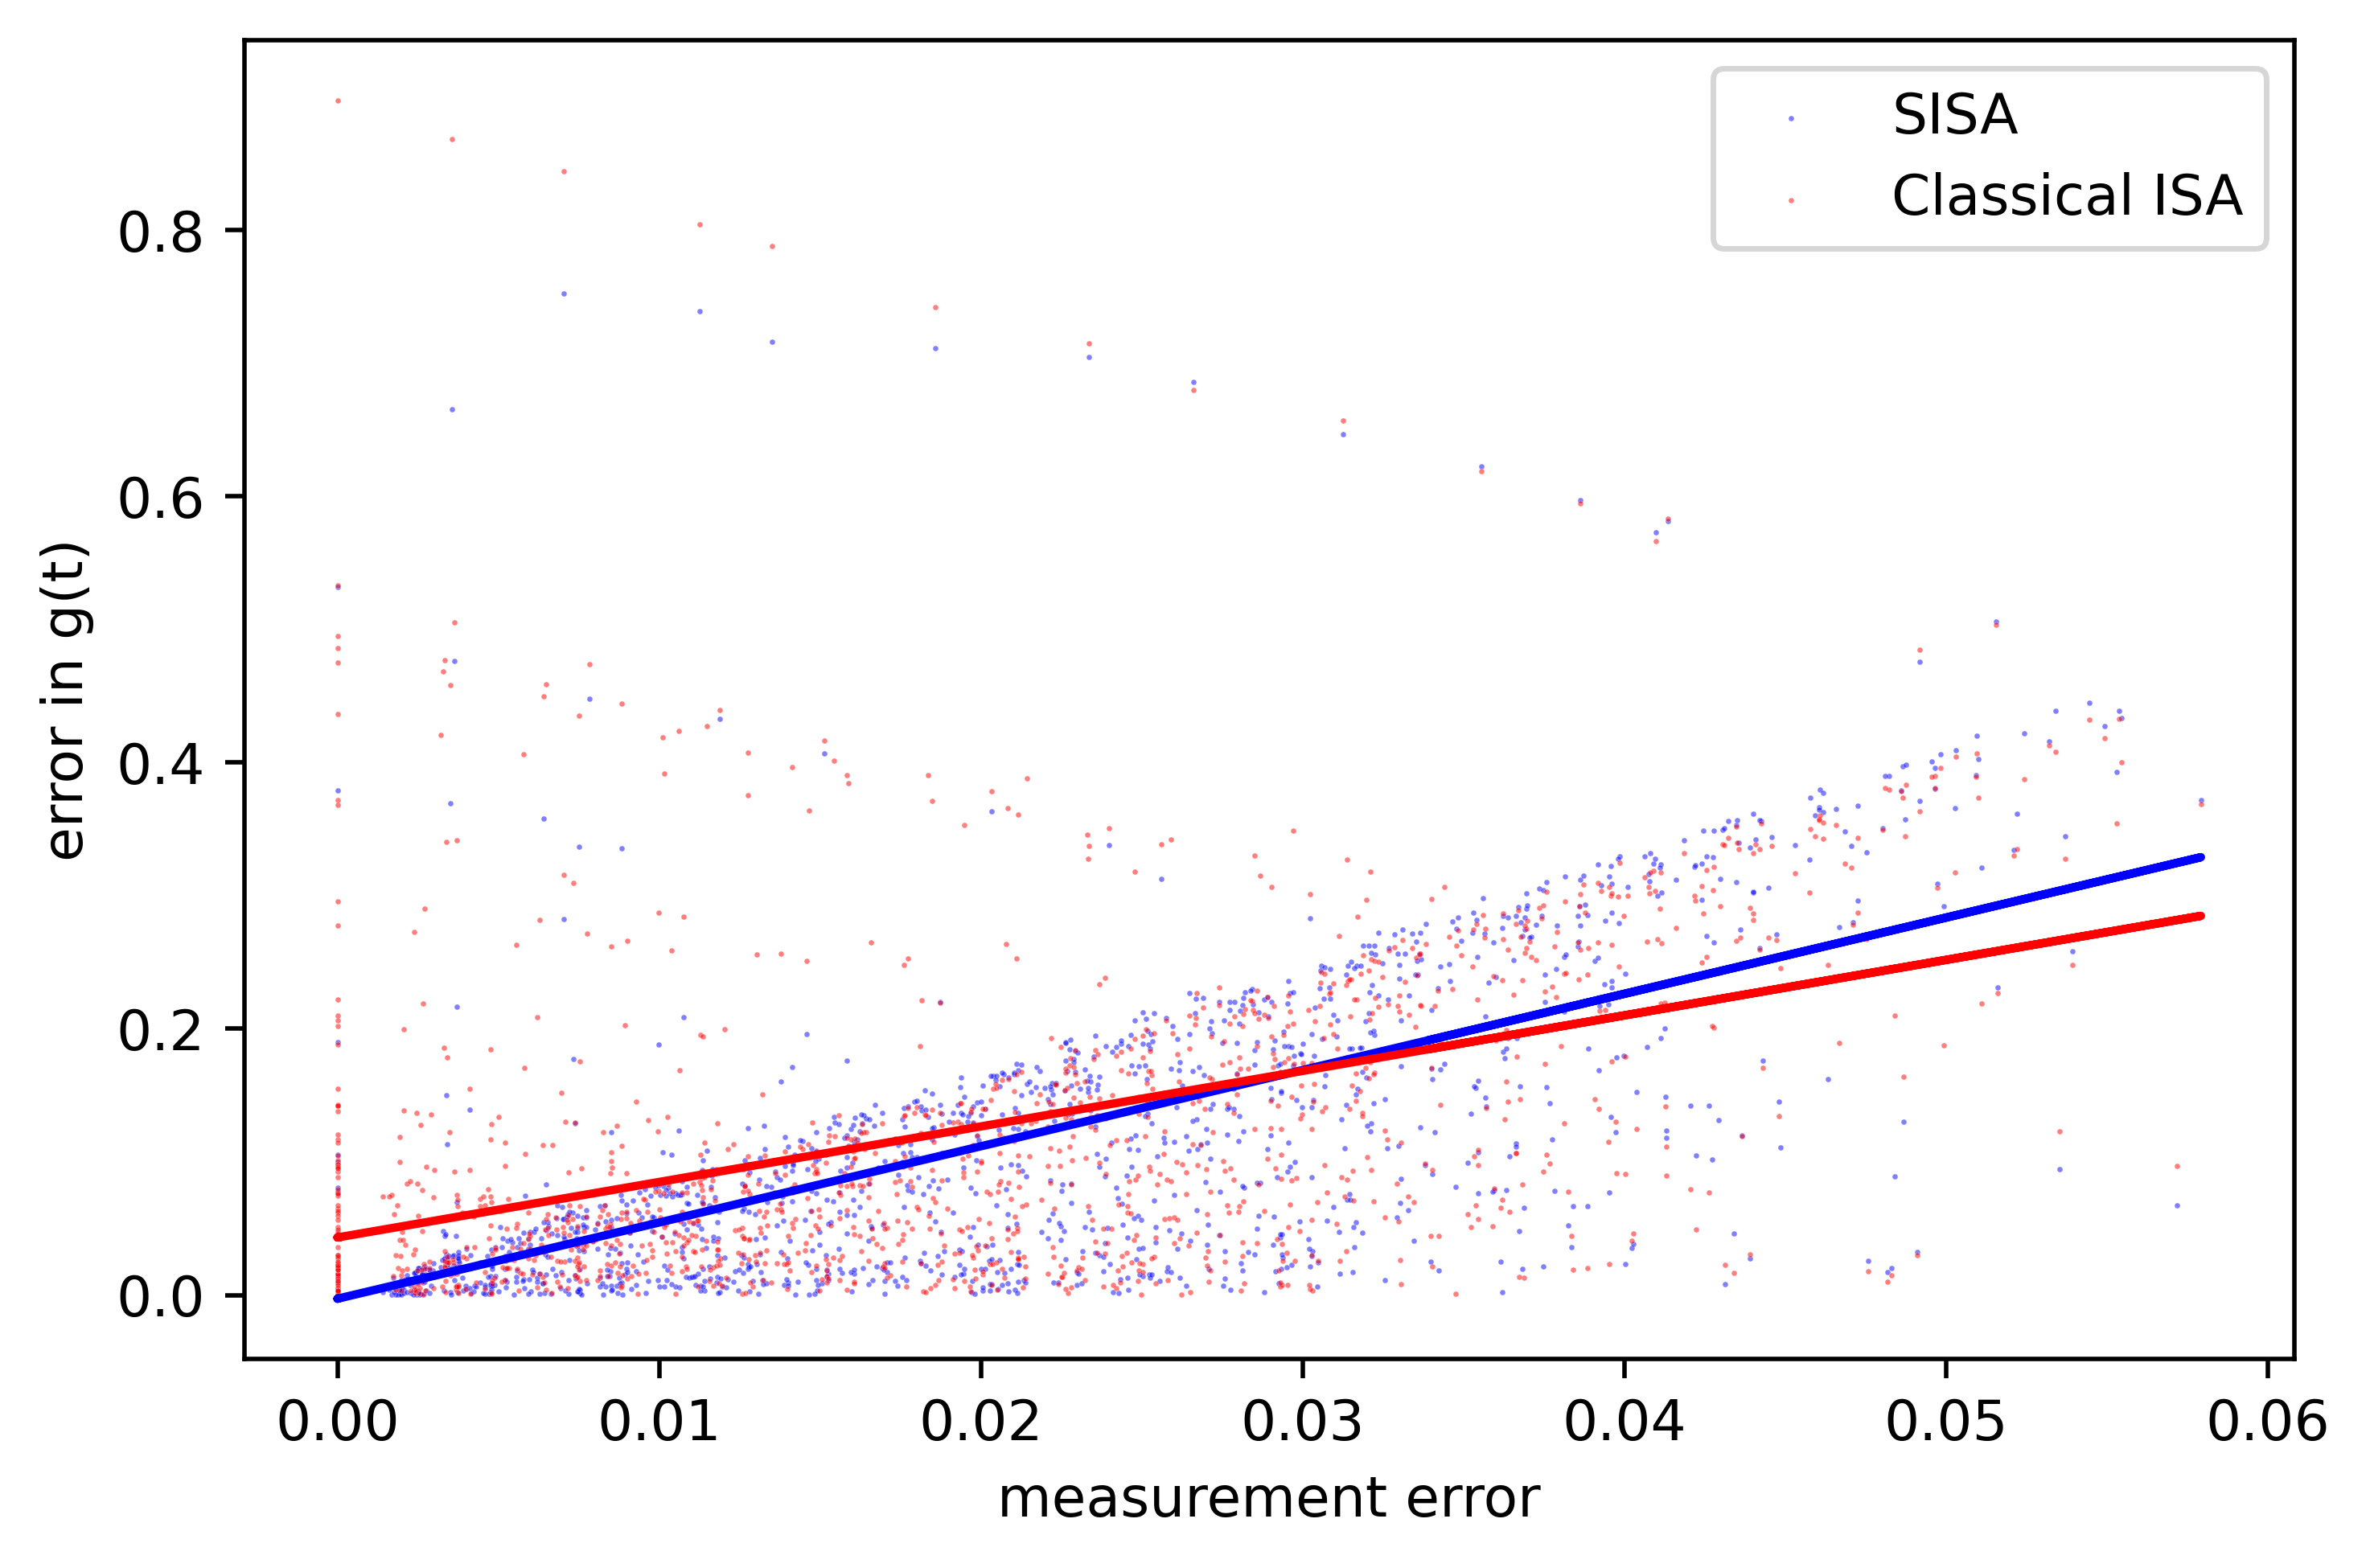

In [53]:
palette = {"SISA":"blue","Classical ISA":"red"}

for method,color in palette.items():
    filt = plt_dict[plt_dict["method"] == method]
    #sb.regplot(data=plt_dict[plt_dict["method"] == method],x="measurement error",y="error in g(t)",ci=95,scatter_kws={"s": .1,"alpha":0.5},color=color,label=method)
    sb.scatterplot(data=plt_dict[plt_dict["method"] == method],x="measurement error",y="error in g(t)", s = 1,alpha=0.5,color=color,label=method)
    linReg = LinearRegression()
    linReg.fit(filt["measurement error"].values.reshape(-1,1),filt["error in g(t)"].values)
    pred = linReg.predict(filt["measurement error"].values.reshape(-1,1))
    plt.plot(filt["measurement error"].values,pred,color=color)
plt.tight_layout()
plt.savefig("../figures_presentations/model_comparision_scatter.png")
plt.legend()


In [54]:
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/desi/12C/"
[peaklist,msis] = pkl.load(open(datadir + "processed_data.pkl","rb"))

In [55]:
msi = msis[list(msis.keys())[0]]

In [56]:
inds = -1
targ = "C16H32O2"
for index,row in peaklist.iterrows():
    if row["formula"] == targ:
        inds = row["inds"]
        break
inds

[162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178]

In [57]:
#calculation labeling pattern images and save result
goodInds = [x for x in range(len(msi.data_tensor)) if x not in [1,4,5]]
iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor[inds])

In [58]:
patterns = []
for row in range(iso_tensor.shape[1]):
    for col in range(iso_tensor.shape[2]):
        if msi.imageBoundary[row,col] > 0.5:
            patterns.append(iso_tensor[:,row,col])
print(len(patterns))

21062


In [59]:
truePattern = isa_func(1.0,0,0,1.0,0,0,1.0,0.0,0.0)
print(truePattern)

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


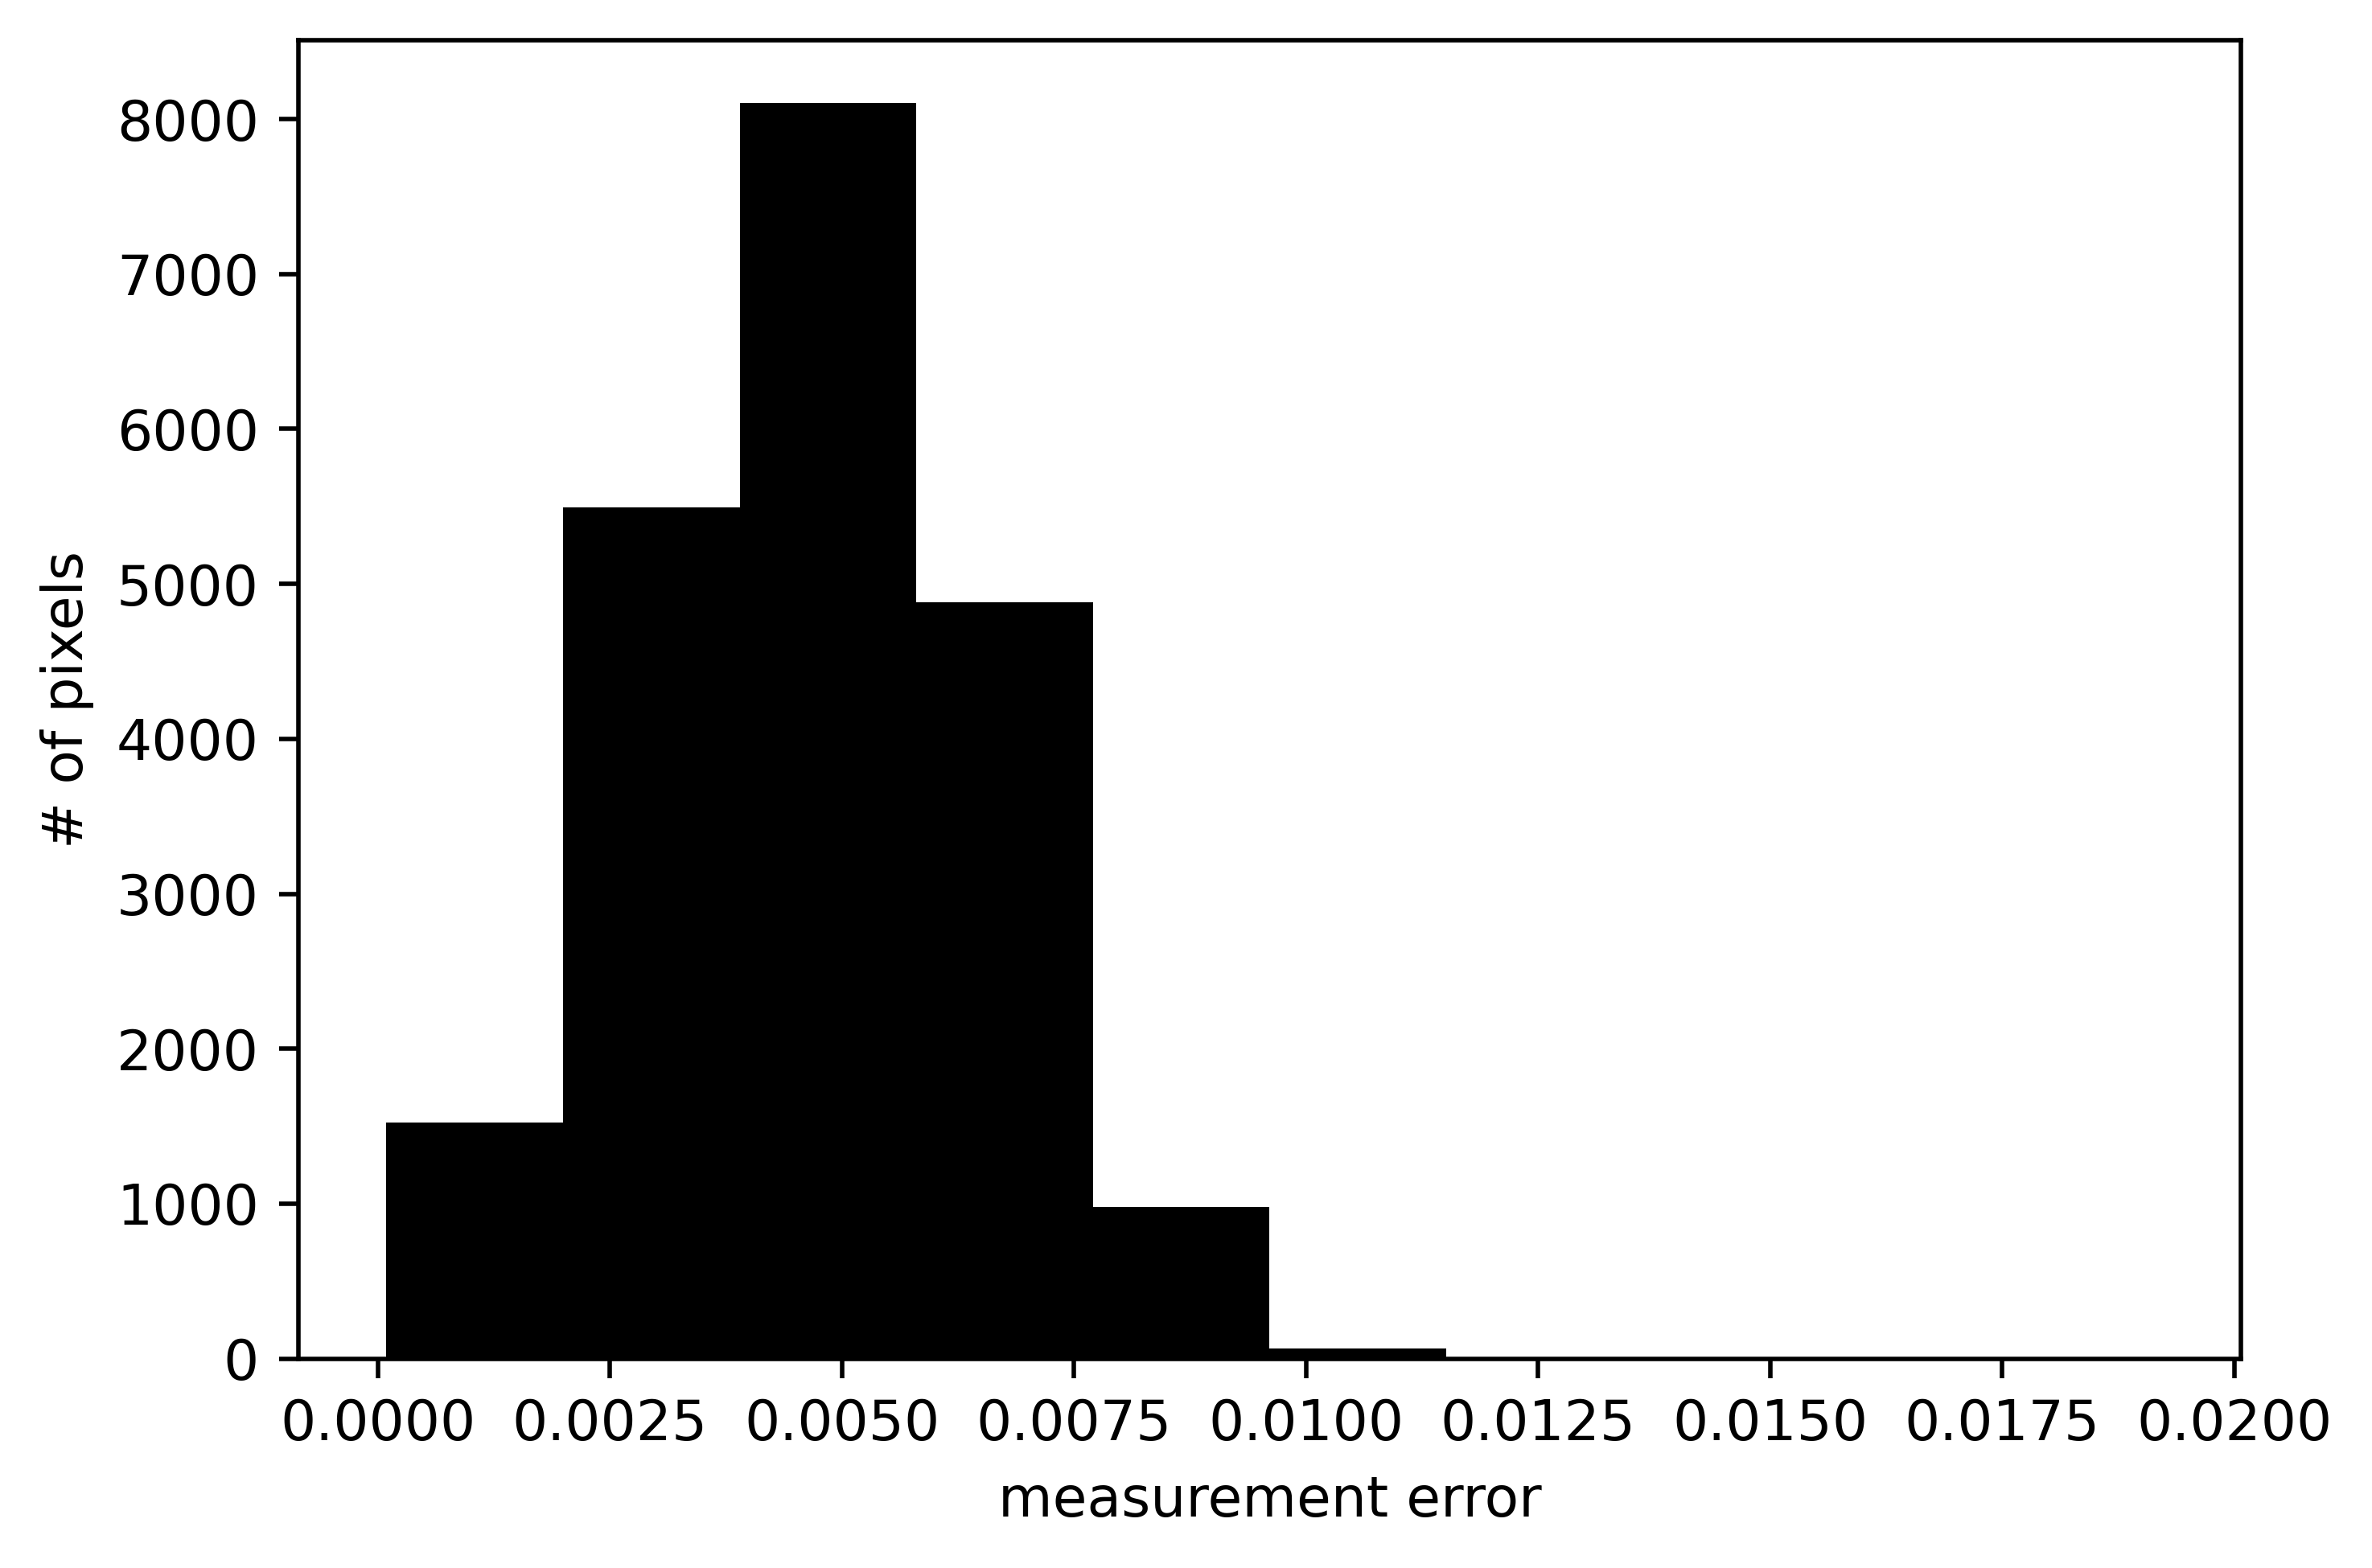

In [60]:
errs = []
for pattern in patterns:
    err_measure = np.mean([np.abs(x-y) for x,y in zip(pattern,truePattern)])
    errs.append(err_measure)
plt.hist(errs,color="black")
plt.xlabel("measurement error")
plt.ylabel("# of pixels")
plt.tight_layout()
plt.savefig("../figures_presentations/measurement_error_hist.png")

Text(0, 0.5, '# of pixels')

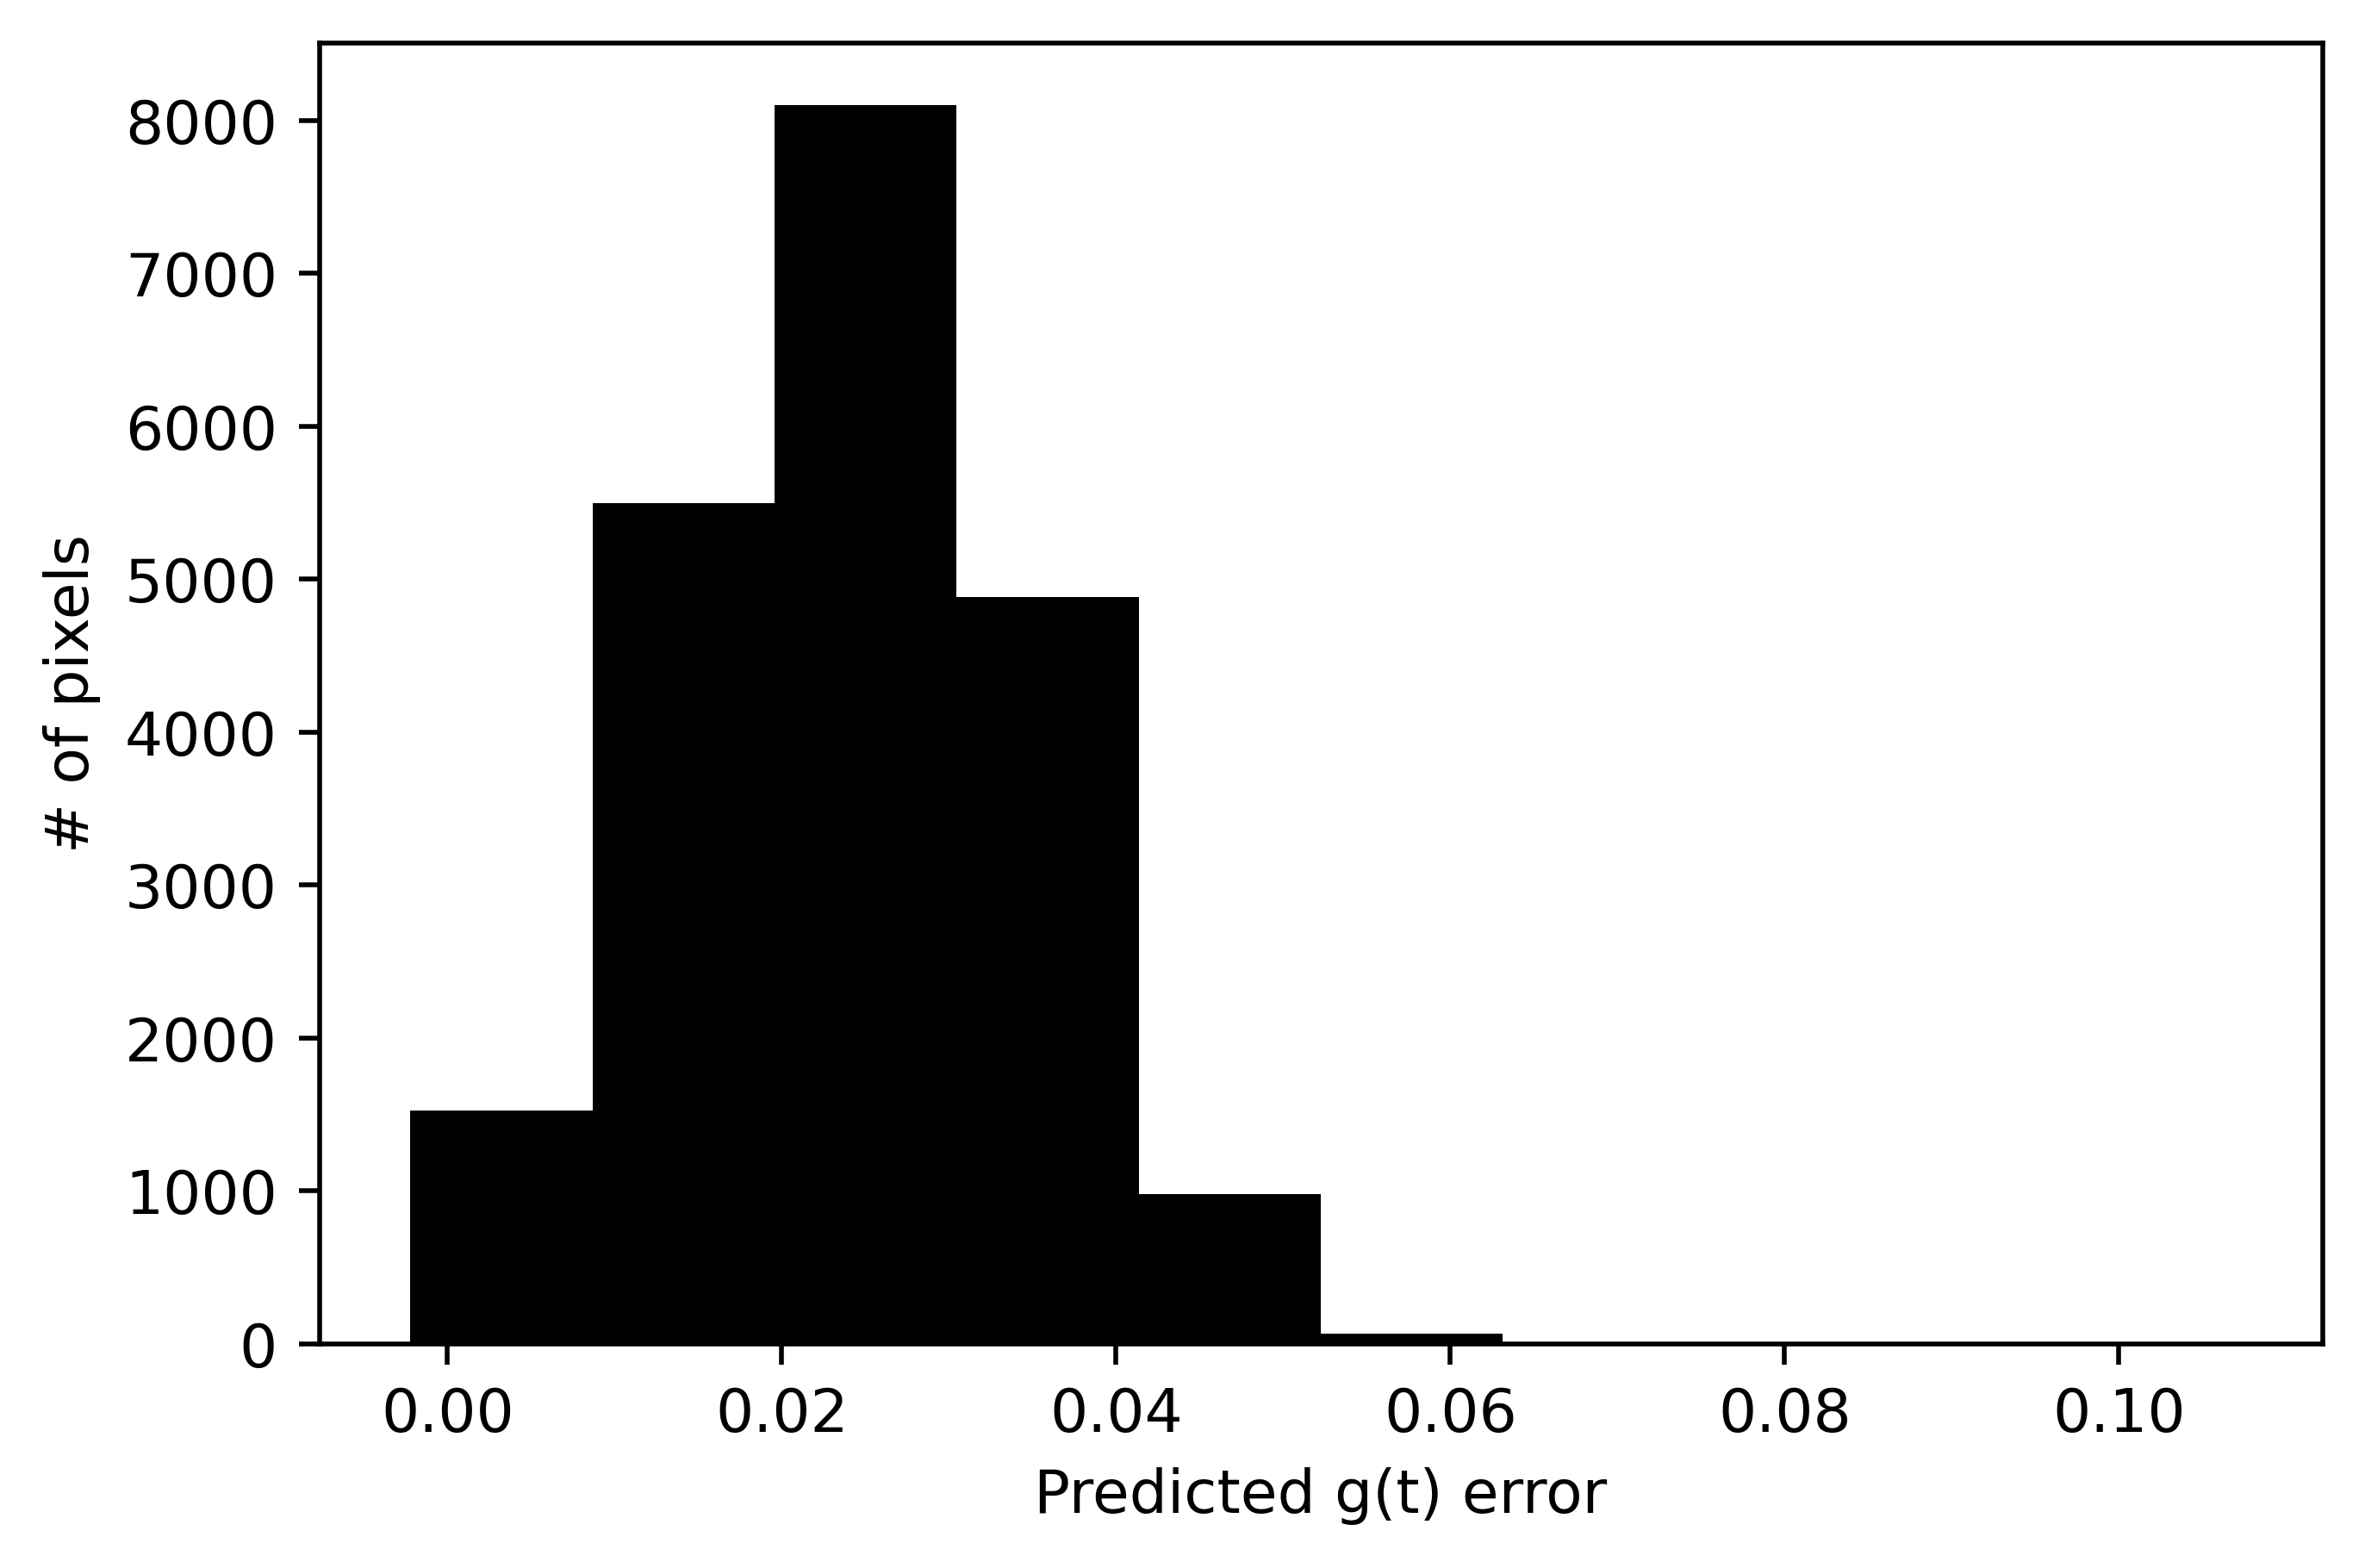

In [61]:
gerrs = []
xerrs = []
for err in errs:
    gerrs.append(models["error in g(t)"](err).tolist())

plt.hist(gerrs,color="black")
plt.xlabel("Predicted g(t) error")
plt.ylabel("# of pixels")

In [67]:
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/desi/13C/"
[peaklist,msis,fluxImages] = pkl.load(open(datadir + "processed_data.pkl","rb"))

In [68]:
key = "20221028_mt_tumor_brain4-2_12B_13C_10um_70-560mz Analyte 1_1_recal.imzML"

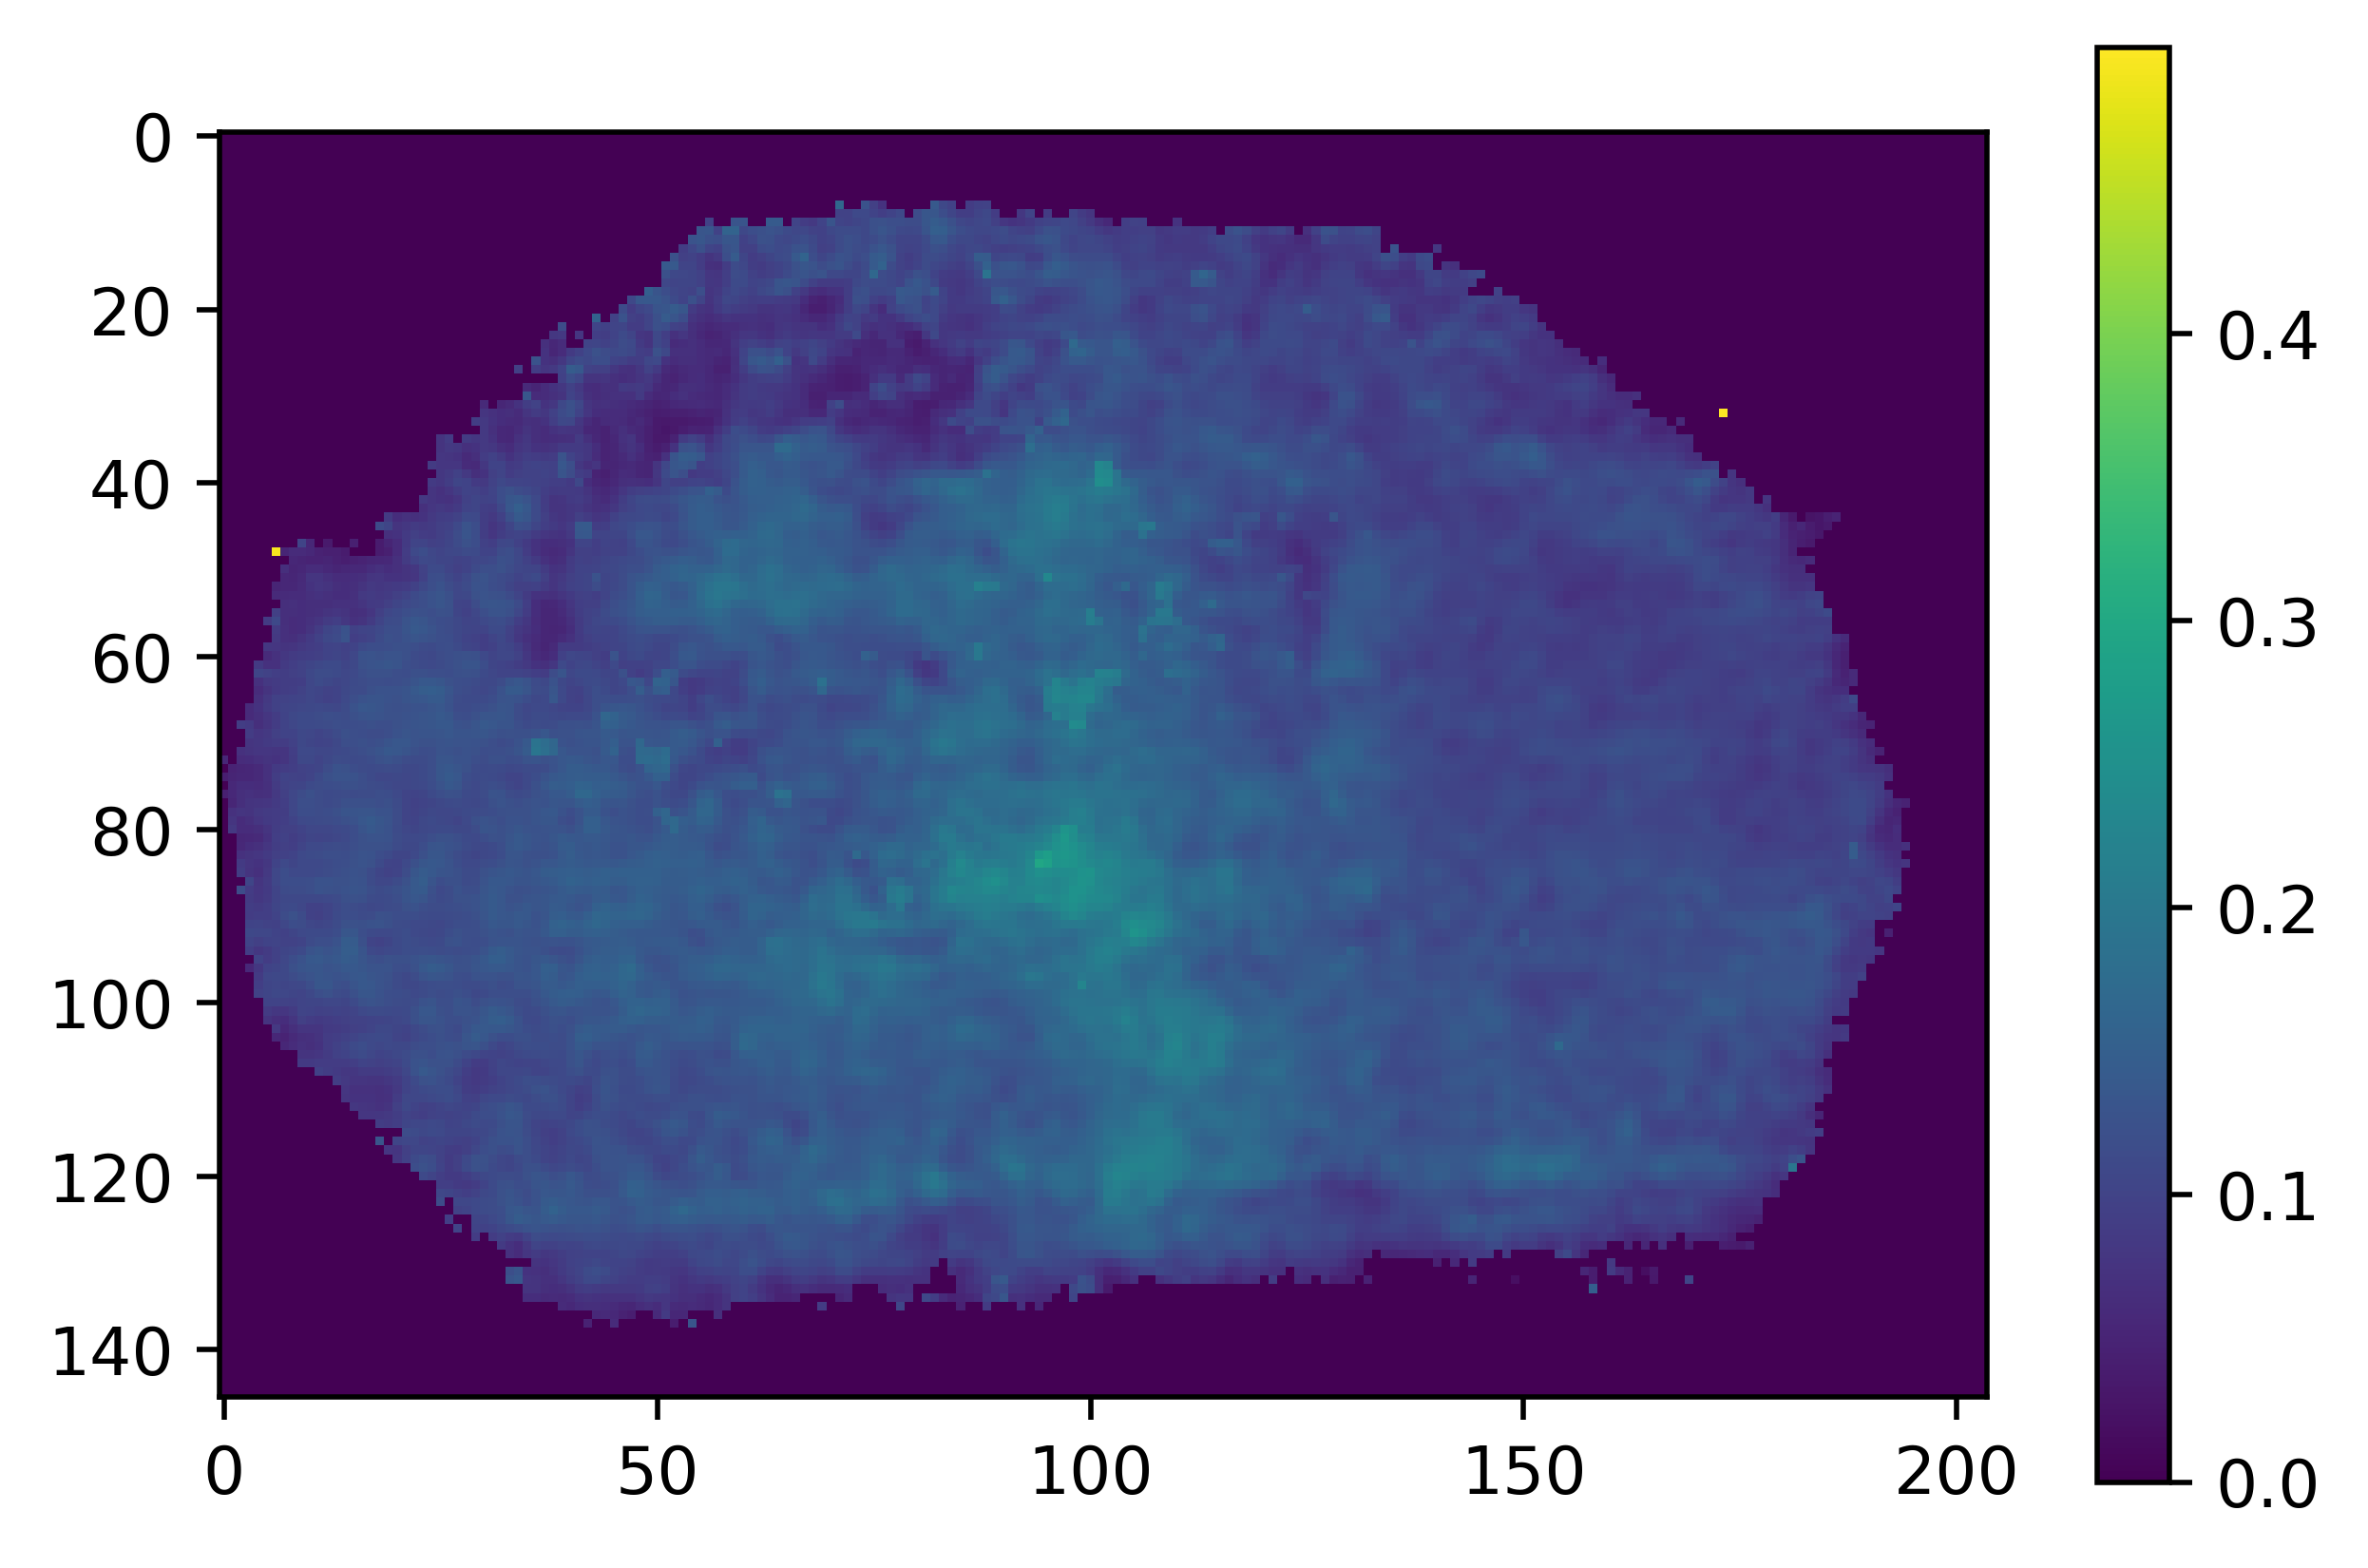

In [69]:
fluxImage = fluxImages[key]["palmitate"]["g"]
plt.imshow(fluxImage)
plt.colorbar()

In [70]:
vals = fluxImage[msis[key].imageBoundary > 0.5].flatten()

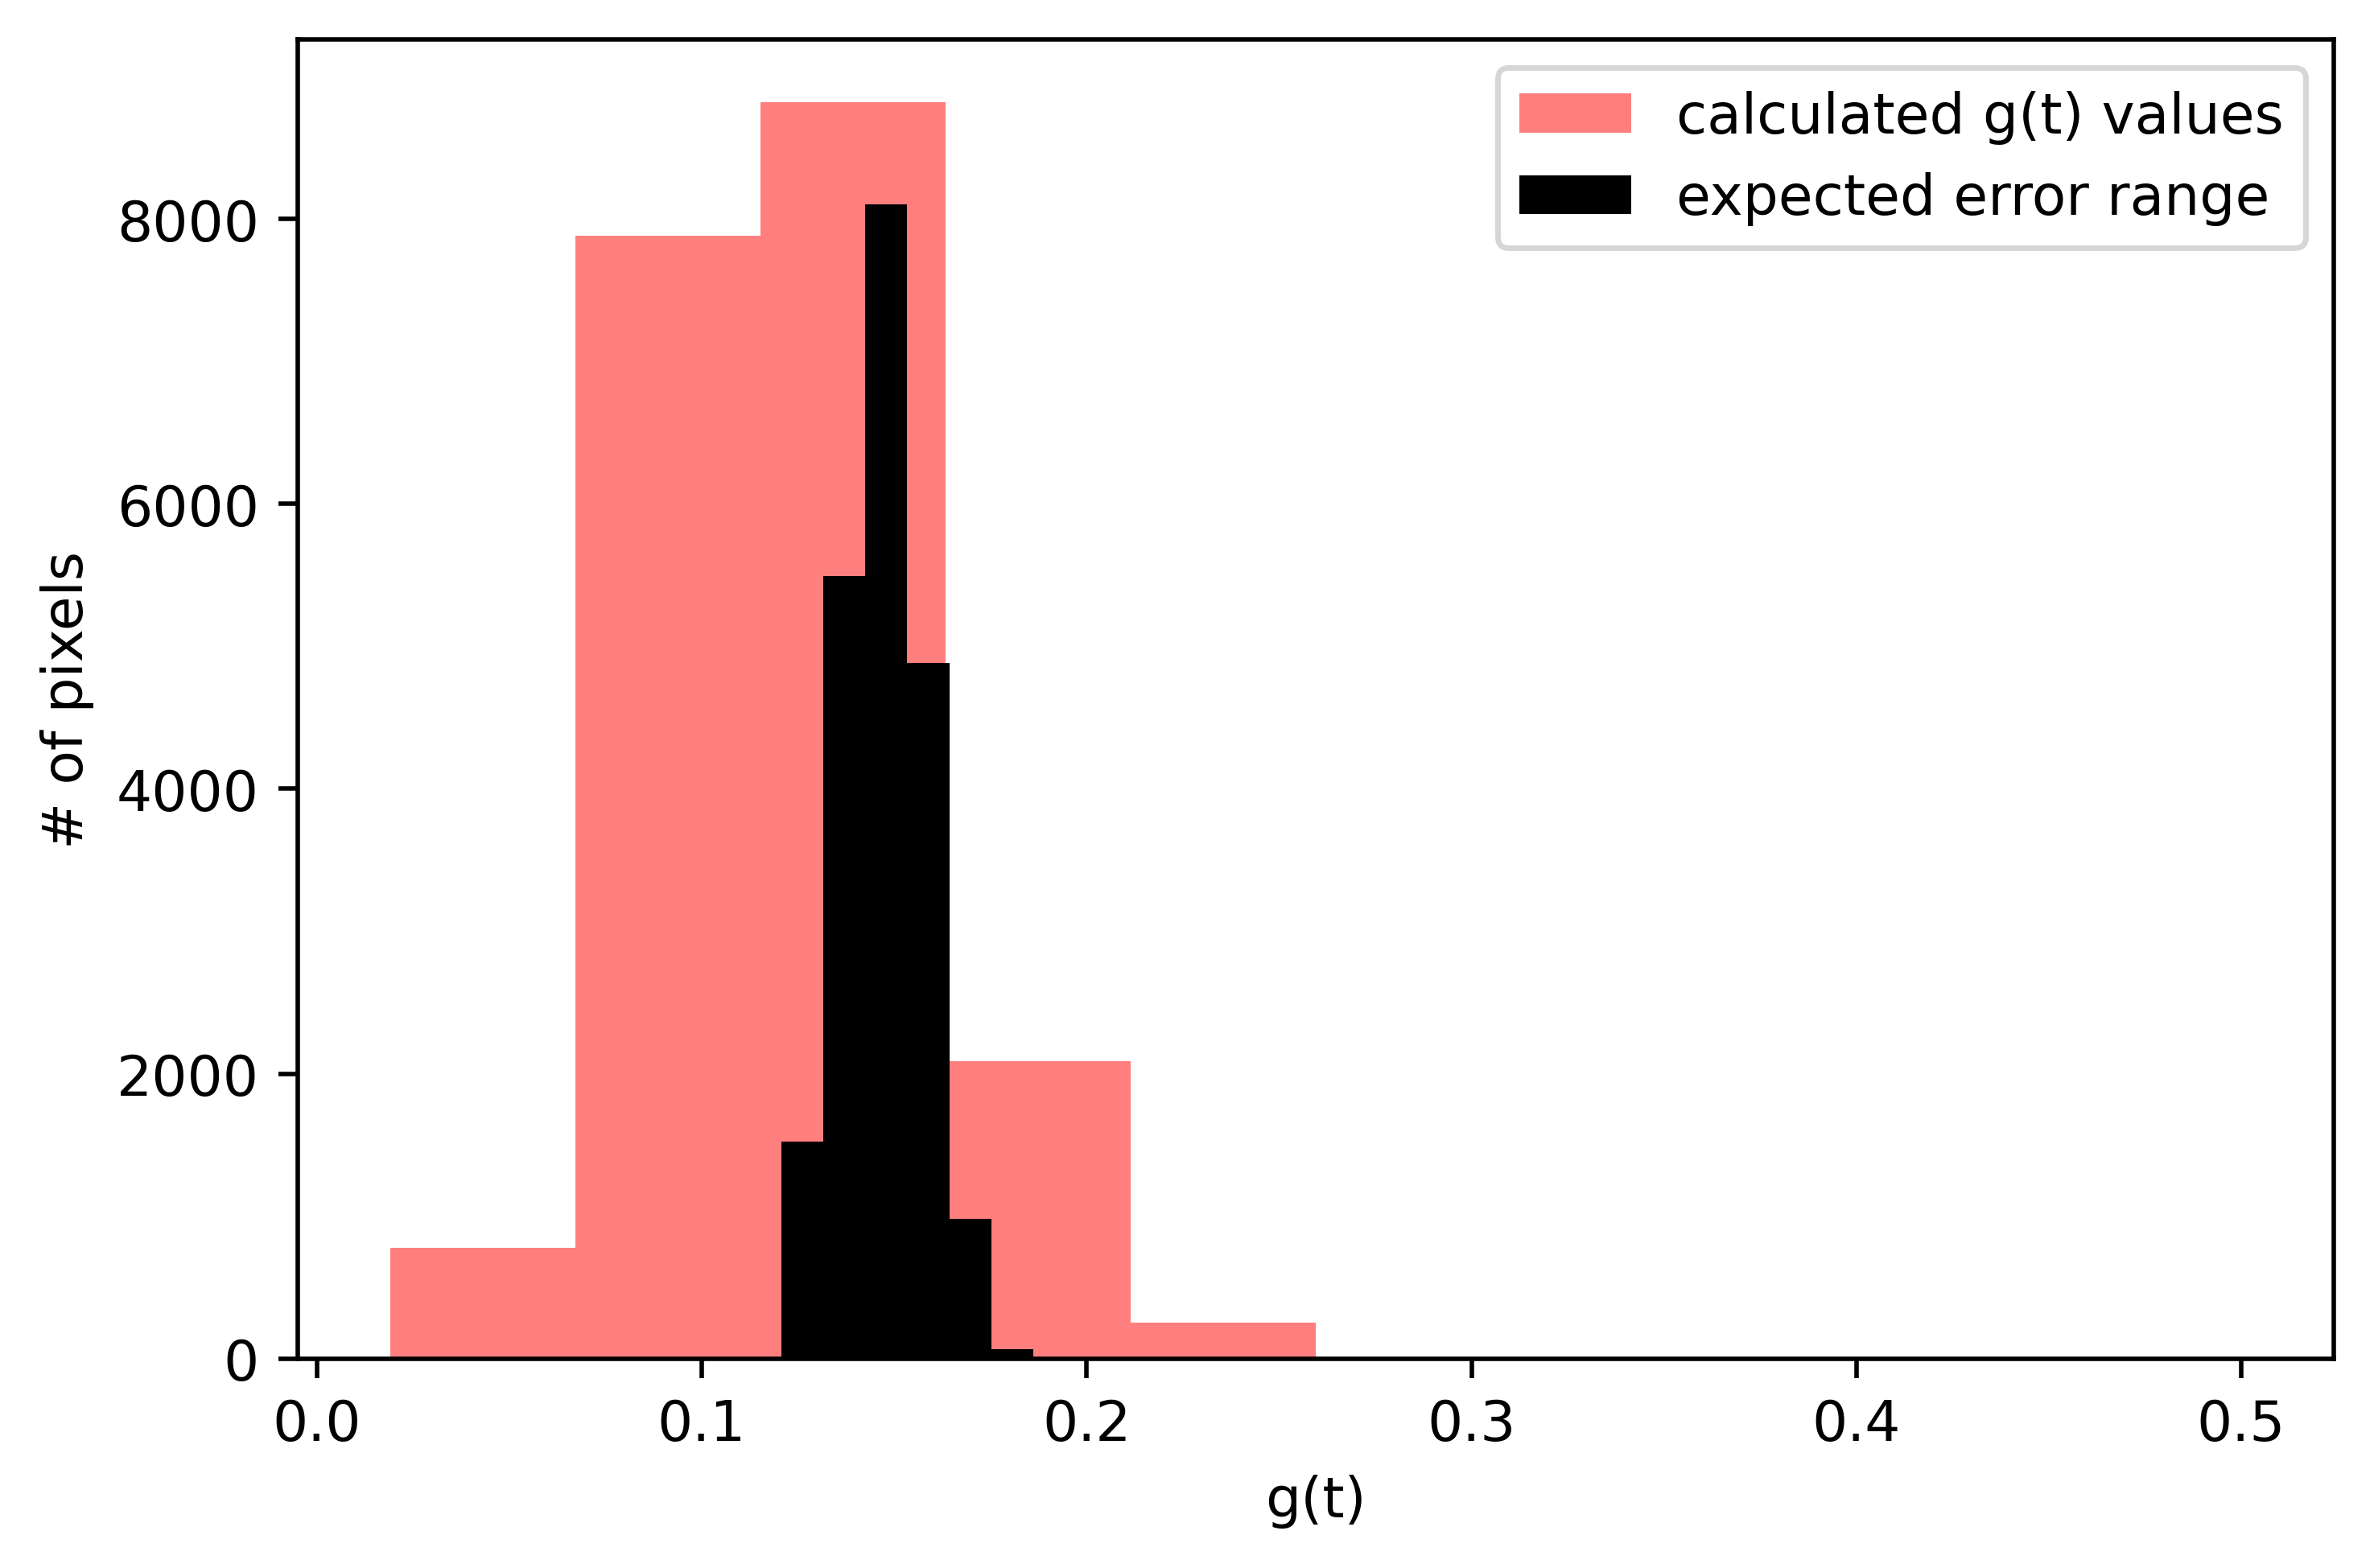

In [71]:
gerrs_shifted = gerrs + np.mean(vals)
plt.hist(vals,color="red",alpha=0.5,label="calculated g(t) values")
plt.hist(gerrs_shifted,color="black",alpha=1.0,label="expected error range")
plt.xlabel("g(t)")
plt.ylabel("# of pixels")
plt.legend()
plt.tight_layout()
plt.savefig("../figures_presentations/hist_overlay.png")